## **Import necessary library and define global variables**

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_epochs = 50
batch_size = 8
learning_rate = 0.0003

## **Program a data loader for CIFAR-10 dataset:**

In [4]:
torch.manual_seed(43)

#image normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

val_size = 5000
train_size = len(trainset) - val_size
trainset, valset = random_split(trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
train_size

45000

## **Built a LeNet model for image classification:**

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
      nn.Tanh(),
      nn.AvgPool2d(kernel_size=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
      nn.Tanh(),
      nn.AvgPool2d(kernel_size=2),
    )

    self.FCL = nn.Sequential(
      nn.Linear(16*5*5, 120),
      nn.Tanh(),
      nn.Linear(120, 84),
      nn.Tanh(),
      nn.Linear(84, 10),
      nn.LogSoftmax(dim=1)
    )


  def forward(self, x):
      x = self.conv_layers(x)
      x = x.reshape(x.size(0), -1)
      x = self.FCL(x)
      return x

## **Write training frameworks to implement the classification pipeline:**

In [ ]:
model = ConvNet().to(device)
train_losses = []
val_losses = []
criterion = nn.NLLLoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    total_train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    total_val_loss = 0
    for j, (images, labels) in enumerate(val_loader):
      images_val = images.to(device)
      labels_val = labels.to(device)

      outputs_val = model(images_val)

      #by default losses are averaged across observations for each minibatch.
      loss_val = criterion(outputs_val, labels_val)
      total_val_loss += loss_val
    print (f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss/train_size:.4f}, Validation Loss: {total_val_loss/val_size:.4f}')
    train_losses.append(total_train_loss/train_size)
    val_losses.append(total_val_loss/val_size)

Epoch [1/50], Train Loss: 2.0585, Validation Loss: 1.9389
Epoch [2/50], Train Loss: 1.8648, Validation Loss: 1.8252
Epoch [3/50], Train Loss: 1.7635, Validation Loss: 1.7435
Epoch [4/50], Train Loss: 1.6842, Validation Loss: 1.6716
Epoch [5/50], Train Loss: 1.5980, Validation Loss: 1.6020
Epoch [6/50], Train Loss: 1.5247, Validation Loss: 1.5325
Epoch [7/50], Train Loss: 1.4707, Validation Loss: 1.4869
Epoch [8/50], Train Loss: 1.4265, Validation Loss: 1.4428
Epoch [9/50], Train Loss: 1.3902, Validation Loss: 1.4252
Epoch [10/50], Train Loss: 1.3579, Validation Loss: 1.3861
Epoch [11/50], Train Loss: 1.3294, Validation Loss: 1.3736
Epoch [12/50], Train Loss: 1.3039, Validation Loss: 1.3492
Epoch [13/50], Train Loss: 1.2810, Validation Loss: 1.3533
Epoch [14/50], Train Loss: 1.2577, Validation Loss: 1.3108
Epoch [15/50], Train Loss: 1.2355, Validation Loss: 1.2973
Epoch [16/50], Train Loss: 1.2164, Validation Loss: 1.2973
Epoch [17/50], Train Loss: 1.1981, Validation Loss: 1.2704
Epoch 

## **Plot the loss for train and validation**

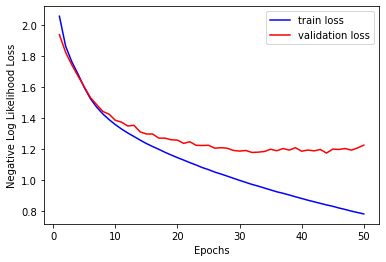

In [ ]:
x = [i+1 for i in range(50)]
plt.plot(x, train_losses, color = "blue", label = "train loss")
plt.plot(x, val_losses, color = "red", label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood Loss")
plt.legend()
plt.show()

## **Write testing framework to evaluate the classification pipeline**

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
          n_samples += 1
          if predicted[i] == labels[i]:
            n_correct += 1
            n_class_correct[labels[i]] += 1
          n_class_samples[labels[i]] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Total Accuracy: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Total Accuracy: 60.25 %
Accuracy of plane: 62.7 %
Accuracy of car: 75.4 %
Accuracy of bird: 36.3 %
Accuracy of cat: 38.0 %
Accuracy of deer: 59.8 %
Accuracy of dog: 50.4 %
Accuracy of frog: 70.6 %
Accuracy of horse: 68.2 %
Accuracy of ship: 73.8 %
Accuracy of truck: 67.3 %


## **improve the Lenet model by changing the optimizer from SGD to Adam and calculating validation accuracy instead of validation loss during training**

In [ ]:
#Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. 
import torch.optim as optim
epoches = 200
model_3 = ConvNet().to(device)
train_losses = []
val_losses = []
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model_3.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
n_total_steps = len(train_loader)

for epoch in range(epoches):
    total_train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
      images_val = images.to(device)
      labels_val = labels.to(device)
      outputs_val = model_3(images_val)
      _, val_predicted = torch.max(outputs_val, 1)
      for i in range(len(val_predicted)):
        n_samples += 1
        if val_predicted[i] == labels[i]:
          n_correct += 1
    acc = 100.0 * n_correct / n_samples
    print (f'Epoch [{epoch+1}/{epoches}], Train Loss: {total_train_loss/train_size:.4f}, Validation Accuracy:{acc} %')
    train_losses.append(total_train_loss/train_size)
    val_losses.append(acc)

Epoch [1/200], Train Loss: 1.9113, Validation Accuracy:35.08 %
Epoch [2/200], Train Loss: 1.7670, Validation Accuracy:38.66 %
Epoch [3/200], Train Loss: 1.7009, Validation Accuracy:40.44 %
Epoch [4/200], Train Loss: 1.6469, Validation Accuracy:41.26 %
Epoch [5/200], Train Loss: 1.5945, Validation Accuracy:42.36 %
Epoch [6/200], Train Loss: 1.5465, Validation Accuracy:44.4 %
Epoch [7/200], Train Loss: 1.5041, Validation Accuracy:45.54 %
Epoch [8/200], Train Loss: 1.4677, Validation Accuracy:45.66 %
Epoch [9/200], Train Loss: 1.4352, Validation Accuracy:47.06 %
Epoch [10/200], Train Loss: 1.4060, Validation Accuracy:48.72 %
Epoch [11/200], Train Loss: 1.3816, Validation Accuracy:49.22 %
Epoch [12/200], Train Loss: 1.3598, Validation Accuracy:49.68 %
Epoch [13/200], Train Loss: 1.3407, Validation Accuracy:50.14 %
Epoch [14/200], Train Loss: 1.3222, Validation Accuracy:51.4 %
Epoch [15/200], Train Loss: 1.3058, Validation Accuracy:51.48 %
Epoch [16/200], Train Loss: 1.2911, Validation Accu

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
          n_samples += 1
          if predicted[i] == labels[i]:
            n_correct += 1
            n_class_correct[labels[i]] += 1
          n_class_samples[labels[i]] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Total Accuracy: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Total Accuracy: 56.16 %
Accuracy of plane: 60.7 %
Accuracy of car: 68.1 %
Accuracy of bird: 46.0 %
Accuracy of cat: 39.4 %
Accuracy of deer: 46.6 %
Accuracy of dog: 50.5 %
Accuracy of frog: 63.2 %
Accuracy of horse: 60.1 %
Accuracy of ship: 67.6 %
Accuracy of truck: 59.4 %


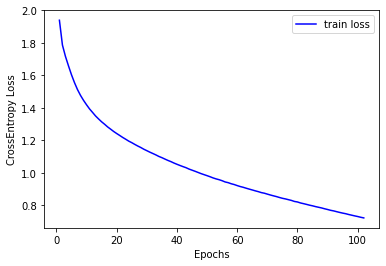

In [ ]:
x = [i+1 for i in range(102)]
plt.plot(x, train_losses, color = "blue", label = "train loss")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood Loss")
plt.legend()
plt.show()

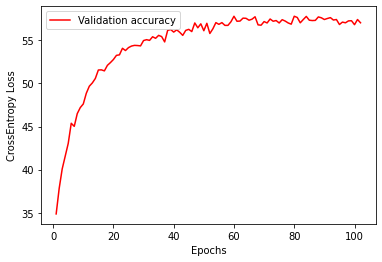

In [ ]:
x = [i+1 for i in range(102)]
plt.plot(x, val_losses, color = "red", label = "Validation accuracy")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood Loss")
plt.legend()
plt.show()

In [7]:
class ConvNet_2(nn.Module):
  def __init__(self):
    super(ConvNet_2, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(3, 16, 3, 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      # nn.AvgPool2d(kernel_size=2),
      nn.Conv2d(16, 32, 3, 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(32, 64, 3, 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.FCL = nn.Sequential(
      nn.Linear(4*4*64, 500),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(500, 10),
      nn.LogSoftmax(dim=1)
    )


  def forward(self, x):
      x = self.conv_layers(x)
      x = x.reshape(x.size(0), -1)
      x = self.FCL(x)
      return x

In [8]:
#Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. 
import torch.optim as optim
epoches = 100
model_5 = ConvNet_2().to(device)
train_losses = []
val_losses = []
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model_5.parameters(), lr=0.0001)
n_total_steps = len(train_loader)

for epoch in range(epoches):
    total_train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_5(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
      images_val = images.to(device)
      labels_val = labels.to(device)
      outputs_val = model_5(images_val)
      _, val_predicted = torch.max(outputs_val, 1)
      for i in range(len(val_predicted)):
        n_samples += 1
        if val_predicted[i] == labels[i]:
          n_correct += 1
    acc = 100.0 * n_correct / n_samples
    print (f'Epoch [{epoch+1}/{epoches}], Train Loss: {total_train_loss/train_size:.4f}, Validation Accuracy:{acc} %')
    train_losses.append(total_train_loss/train_size)
    val_losses.append(acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/100], Train Loss: 1.7220, Validation Accuracy:45.08 %
Epoch [2/100], Train Loss: 1.4159, Validation Accuracy:50.16 %
Epoch [3/100], Train Loss: 1.2845, Validation Accuracy:54.06 %
Epoch [4/100], Train Loss: 1.1835, Validation Accuracy:57.38 %
Epoch [5/100], Train Loss: 1.1030, Validation Accuracy:59.88 %
Epoch [6/100], Train Loss: 1.0305, Validation Accuracy:61.94 %
Epoch [7/100], Train Loss: 0.9706, Validation Accuracy:63.06 %
Epoch [8/100], Train Loss: 0.9185, Validation Accuracy:64.14 %
Epoch [9/100], Train Loss: 0.8710, Validation Accuracy:64.84 %
Epoch [10/100], Train Loss: 0.8266, Validation Accuracy:66.1 %
Epoch [11/100], Train Loss: 0.7872, Validation Accuracy:67.68 %
Epoch [12/100], Train Loss: 0.7497, Validation Accuracy:68.36 %
Epoch [13/100], Train Loss: 0.7168, Validation Accuracy:67.92 %
Epoch [14/100], Train Loss: 0.6830, Validation Accuracy:68.4 %
Epoch [15/100], Train Loss: 0.6538, Validation Accuracy:69.92 %
Epoch [16/100], Train Loss: 0.6230, Validation Accu

KeyboardInterrupt: ignored

In [9]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_5(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
          n_samples += 1
          if predicted[i] == labels[i]:
            n_correct += 1
            n_class_correct[labels[i]] += 1
          n_class_samples[labels[i]] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Total Accuracy: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Total Accuracy: 70.96 %
Accuracy of plane: 75.9 %
Accuracy of car: 82.4 %
Accuracy of bird: 56.9 %
Accuracy of cat: 50.0 %
Accuracy of deer: 64.0 %
Accuracy of dog: 64.1 %
Accuracy of frog: 75.2 %
Accuracy of horse: 74.2 %
Accuracy of ship: 85.1 %
Accuracy of truck: 81.8 %


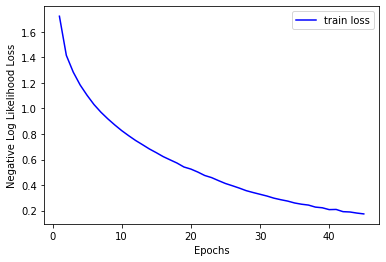

In [11]:
x = [i+1 for i in range(45)]
plt.plot(x, train_losses, color = "blue", label = "train loss")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood Loss")
plt.legend()
plt.show()

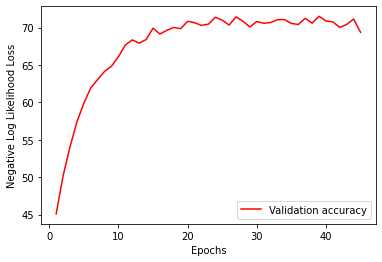

In [12]:
x = [i+1 for i in range(45)]
plt.plot(x, val_losses, color = "red", label = "Validation accuracy")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood Loss")
plt.legend()
plt.show()

## **Build VGG-19**

In [ ]:
from torch.autograd import Variable
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self.make_layers(vgg_name)
        self.classifier = nn.Linear(512, 10)
        self.activation = nn.LogSoftmax(dim=1)


    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = self.activation(out)
        return out

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


## **VGGnet Model Training**

In [ ]:
import torch.optim as optim
net_arch19 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
epoches = 400
model_4 = VGG(net_arch19).to(device)
train_losses = []
val_losses = []
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model_4.parameters(), lr=0.00005)
n_total_steps = len(train_loader)

for epoch in range(epoches):
    total_train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_4(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      
    n_correct = 0
    n_samples = 0
    for images, labels in val_loader:
      images_val = images.to(device)
      labels_val = labels.to(device)
      outputs_val = model_4(images_val)
      _, val_predicted = torch.max(outputs_val, 1)
      for i in range(len(val_predicted)):
        n_samples += 1
        if val_predicted[i] == labels[i]:
          n_correct += 1
    acc = 100.0 * n_correct / n_samples
    print (f'Epoch [{epoch+1}/{epoches}], Train Loss: {total_train_loss/train_size:.4f}, Validation Accuracy:{acc} %')
    train_losses.append(total_train_loss/train_size)
    val_losses.append(acc)

Epoch [1/400], Train Loss: 1.4296, Validation Accuracy:59.88 %
Epoch [2/400], Train Loss: 0.9580, Validation Accuracy:69.54 %
Epoch [3/400], Train Loss: 0.7290, Validation Accuracy:74.4 %
Epoch [4/400], Train Loss: 0.5876, Validation Accuracy:77.74 %
Epoch [5/400], Train Loss: 0.4707, Validation Accuracy:79.56 %
Epoch [6/400], Train Loss: 0.3812, Validation Accuracy:78.24 %
Epoch [7/400], Train Loss: 0.3083, Validation Accuracy:79.8 %
Epoch [8/400], Train Loss: 0.2489, Validation Accuracy:80.18 %
Epoch [9/400], Train Loss: 0.2093, Validation Accuracy:80.4 %
Epoch [10/400], Train Loss: 0.1735, Validation Accuracy:80.94 %
Epoch [11/400], Train Loss: 0.1480, Validation Accuracy:81.8 %
Epoch [12/400], Train Loss: 0.1307, Validation Accuracy:82.16 %
Epoch [13/400], Train Loss: 0.1108, Validation Accuracy:81.52 %
Epoch [14/400], Train Loss: 0.1025, Validation Accuracy:82.36 %
Epoch [15/400], Train Loss: 0.0921, Validation Accuracy:82.16 %
Epoch [16/400], Train Loss: 0.0816, Validation Accura

KeyboardInterrupt: ignored

## **Accuracy for VGG-19**

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_4(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
          n_samples += 1
          if predicted[i] == labels[i]:
            n_correct += 1
            n_class_correct[labels[i]] += 1
          n_class_samples[labels[i]] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Total Accuracy: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Total Accuracy: 80.62 %
Accuracy of plane: 81.6 %
Accuracy of car: 95.4 %
Accuracy of bird: 69.4 %
Accuracy of cat: 75.2 %
Accuracy of deer: 72.5 %
Accuracy of dog: 74.5 %
Accuracy of frog: 77.9 %
Accuracy of horse: 91.8 %
Accuracy of ship: 84.5 %
Accuracy of truck: 83.4 %


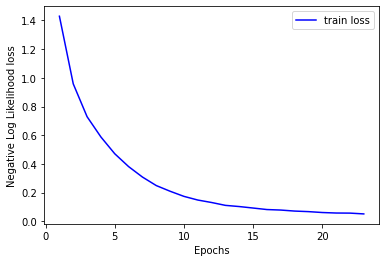

In [ ]:
x = [i+1 for i in range(23)]
plt.plot(x, train_losses, color = "blue", label = "train loss")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood loss")
plt.legend()
plt.show()

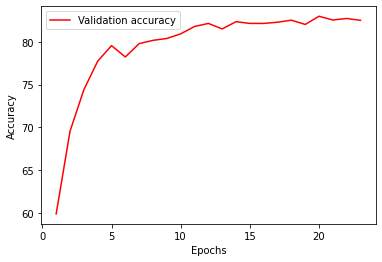

In [ ]:
x = [i+1 for i in range(23)]
plt.plot(x, val_losses, color = "red", label = "Validation accuracy")
# plt.plot(x, val_losses, color = "red", label = "validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()